In [46]:

%matplotlib inline
from itertools import chain
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
from abc import ABC
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()
from collections import defaultdict
from typing import Any

from sklearn import metrics
from matplotlib import pyplot as plt


In [183]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

# pip install github:https://github.com/mederrata/bayesianquilts
from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics, auroc, auprc
from bayesianquilts.sampler import psis, nppsis


In [48]:

X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)


X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(54, 1536)


In [49]:
logistic_horseshoe_code = """
data {
  int <lower=0> N;                // number  of  observations
  int <lower=0> d;                // number  of  predictors
  array[N] int<lower=0,upper=1> y;      // outputs
  matrix[N,d] x;                  // inputs
  real <lower=0>  scale_icept;    // prior  std for  the  intercept
  real <lower=0>  scale_global;   // scale  for  the half -t prior  for  tau
  real <lower=1>  nu_global;      // degrees  of  freedom  for the half -t prior for tau
  real <lower=1> nu_local;        // degrees  of  freedom  for  the half -t priors for  lambdas
  real <lower=0>  slab_scale;     // slab  scale  for  the  regularized  horseshoe
  real <lower=0> slab_df;         // slab  degrees  of  freedom  for the  regularized horseshoe

  //int<lower=0> N_tilde;
  //matrix[N_tilde, d] x_tilde;
  //array[N_tilde] int<lower=0,upper=1> y_obs;
}
parameters {
  real  beta0;
  vector[d] z;
  real <lower=0> tau;             // global  shrinkage  parameter
  vector <lower =0>[d] lambda;    // local  shrinkage  parameter
  real <lower=0> caux;
}
transformed  parameters {
  vector <lower =0>[d] lambda_tilde;    // ’truncated ’ local  shrinkage  parameter
  real <lower=0> c;                     // slab  scale
  vector[d] beta;                       // regression  coefficients
  vector[N] f;                          // latent  function  values
  c = slab_scale * sqrt(caux);
  lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2* square(lambda )) );
  beta = z .*  lambda_tilde*tau;
  f = beta0 + x*beta;
}
model {
  z ~ normal(0.0, 1.0); // half -t priors  for  lambdas  and tau , and  inverse -gamma  for c^2
  lambda ~ student_t(nu_local , 0.0, 1.0);
  tau ~ student_t(nu_global , 0.0, scale_global);
  caux ~ inv_gamma (0.5* slab_df , 0.5* slab_df );
  beta0 ~ normal(0.0,  scale_icept );
  y ~ bernoulli_logit(f);
}
generated quantities {
  vector[N] log_lik;
  // vector[N_tilde] loo_log_lik;

  for (nn in 1:N)
    log_lik[nn] = bernoulli_logit_lpmf(y[nn] | x[nn] * beta + beta0);

  //for (nn in 1:N_tilde)
  //  loo_log_lik[nn] = bernoulli_logit_lpmf(y_obs[nn] | x_tilde[nn] * beta + beta0);
}
"""

with open("ovarian_model.stan", 'w') as f:
  f.writelines(logistic_horseshoe_code)


In [50]:
sm = CmdStanModel(stan_file="ovarian_model.stan")

12:40:28 - cmdstanpy - INFO - compiling stan file /home/josh/workspace/bayesianquilts/ovarian_model.stan to exe file /home/josh/workspace/bayesianquilts/ovarian_model


KeyboardInterrupt: 

In [7]:
guessnumrelevcov = N / 10  # 20.
slab_scale = 2.5
scale_icept = 5.0
nu_global = 1
nu_local = 1
slab_df = 1
scale_global = guessnumrelevcov / ((d - guessnumrelevcov) * np.sqrt(N))

control = {"adapt_delta": 0.9999, "max_treedepth": 15}

# shuffle

# shuffled_ndx = np.random.shuffle(np.arange(N))

ovarian_data = {
    "N": N,
    "d": d,
    "slab_df": slab_df,
    "slab_scale": slab_scale,
    "scale_icept": scale_icept,
    "nu_global": 1,
    "nu_local": 1,
    "scale_global": scale_global,
    "y": y_.astype(int)[:, 0].tolist(),
    "x": X_scaled.tolist(),
}

import json

with open("ovarian_data.json", "w") as f:
    json.dump(ovarian_data, f)

In [8]:
print(d)

1536


In [9]:
S = 1800
fit = sm.sample(
    data="ovarian_data.json",
    iter_warmup=15000,
    iter_sampling=S,
    thin=2,
    **control
)

06:50:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:12:37 - cmdstanpy - INFO - CmdStan done processing.


In [10]:
print(fit)

CmdStanMCMC: model=ovarian_model chains=4['method=sample', 'num_samples=1800', 'num_warmup=15000', 'thin=2', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.9999']
 csv_files:
	/tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_1.csv
	/tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_2.csv
	/tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_3.csv
	/tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_4.csv
 output_files:
	/tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_0-stdout.txt
	/tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_1-stdout.txt
	/tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_2-stdout.txt
	/tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_3-stdout.txt


In [11]:
print(fit.diagnose())

Processing csv files: /tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_1.csv, /tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_2.csv, /tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_3.csv, /tmp/tmp79sh6rwv/ovarian_modelw1k8q_jb/ovarian_model-20241009065055_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [12]:
params = fit.stan_variables()
params.keys()
params['c'] = params['c'][:, tf.newaxis]
params['tau'] = params['tau'][:, tf.newaxis]
params['caux'] = params['caux'][:, tf.newaxis]
params['beta0'] = params['beta0'][:, tf.newaxis]


In [13]:

c = slab_scale * tf.math.sqrt(params["caux"])
lambda_tilde = tf.math.sqrt(
    c**2
    * params["lambda"] ** 2
    / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
)
beta_fitted = params["z"] * lambda_tilde * params["tau"]
beta_fitted.shape

TensorShape([3600, 1536])

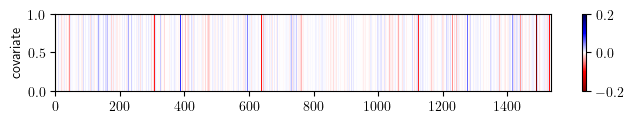

In [14]:
beta_fitted = np.mean(beta_fitted, axis=0, keepdims=True)
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
im = ax.pcolormesh(beta_fitted, cmap='seismic_r', vmin=-0.2, vmax=0.2)
_ = plt.ylabel("covariate")

plt.colorbar(im)
plt.savefig("ovarian_mcmc_fit.pdf", bbox_inches='tight')

In [15]:
lr_model = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [16]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = N
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

0it [00:00, ?it/s]2024-10-09 07:12:52.218398: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2388787200 exceeds 10% of free system memory.
1it [00:00,  2.08it/s]


(0.0, 1.0)

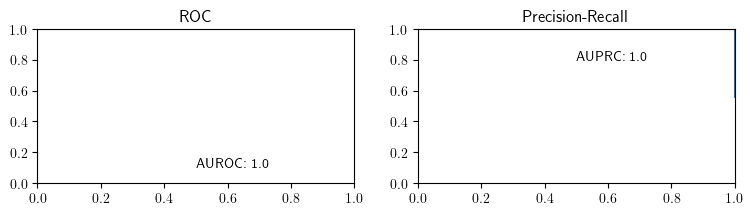

In [17]:
def prediction_fn(data):
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [54]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(
    self: LogisticRegression2,
    data: dict[str, tf.Tensor],
    params,
    hbar=1.0,
    variational=True,
) -> dict[str, Any]:
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    c = self.slab_scale * tf.math.sqrt(params["caux"])
    lambda_tilde = tf.math.sqrt(
        c**2
        * params["lambda"] ** 2
        / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
    )
    beta = params["z"] * lambda_tilde * params["tau"]
    intercept = params["beta0"]
    _X = tf.cast(data["X"], self.dtype)
    _y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = beta[..., tf.newaxis, :] * _X
    mu = tf.reduce_sum(mu, -1) + params["beta0"]
    sigma = tf.math.sigmoid(mu)
    ell = _y * (sigma) + (1 - _y) * (1 - sigma)
    log_ell = tf.math.xlogy(_y, sigma) + tf.math.xlogy(1 - _y, 1 - sigma)
    log_ell_prime = _y * (1 - sigma) - (1 - _y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    ndx_to_transform = np.where(khat0 > 0.7)[0]
    ndx_to_leave = np.where((khat0 <= 0.7))[0]

    def IS(T, X, y):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        # compute # \nabla\log\pi(\btheta|\calD)
        if variational:
            # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
            grad_log_pi = tf.concat(
                [
                    -(
                        intercept
                        - self.surrogate_distribution.model["intercept__"].mean()
                    )
                    / self.surrogate_distribution.model["intercept__"].variance(),
                    -(beta - self.surrogate_distribution.model["beta__"].mean())
                    / self.surrogate_distribution.model["beta__"].variance(),
                ],
                axis=-1,
            )
            intercept_sd = (
                self.surrogate_distribution.model["intercept__"].variance() ** 0.5
            )
            beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

            log_pi = self.surrogate_distribution.model["beta__"].log_prob(
                params["beta__"]
            ) + self.surrogate_distribution.model["intercept__"].log_prob(
                params["intercept__"]
            )
            log_pi -= tf.reduce_max(log_pi, axis=0)
            # log_pi.shape: [samples]
        else:
            """
            Recall Bayes rule:
            \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

            so
            \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

            """
            log_prior = self.prior_distribution.log_prob_parts(params)
            log_prior = log_prior["z"] + log_prior["beta0"]

            log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]

            # pi \propto
            grad_log_pi = tf.concat(
                [
                    tf.reduce_sum(
                        log_ell_prime[..., tf.newaxis], axis=1, keepdims=True
                    ),
                    tf.reduce_sum(
                        log_ell_prime[..., tf.newaxis] * X, axis=1, keepdims=True
                    ),
                ],
                axis=-1,
            )

            grad_log_prior = -0.5 * tf.concat(
                [(params["beta0"] / self.scale_icept) ** 2, (params["z"]) ** 2],
                axis=-1,
            )
            grad_log_pi += grad_log_prior[:, tf.newaxis, :]

            intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
            beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

        beta_new, intercept_new, logJ = T(
            X,
            y,
            log_pi=log_pi,
            grad_log_pi=grad_log_pi,
            beta_sd=beta_sd,
            intercept_sd=intercept_sd,
        )
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.sqrt(
            c**2
            * params["lambda"] ** 2
            / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
        )
        transformed = params.copy()
        transformed["z"] = beta_new / (
            lambda_tilde[:, tf.newaxis, :] * params["tau"][..., tf.newaxis]
        )
        transformed["beta0"] = intercept_new

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * X, -1) + intercept_new
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob_parts(transformed)
            log_prior_new = log_prior_new["z"] + log_prior_new["beta0"]
            log_pi_new = ell_cross
            delta_log_prior = log_prior_new - log_prior[:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior

        # regularize delta_log_pi

        def regularize(tensor):
            min_finite = tf.reduce_min(
                tf.where(
                    tf.math.is_finite(tensor),
                    tensor,
                    tf.zeros_like(tensor),
                )
            )
            return tf.where(
                tf.math.is_finite(tensor),
                tensor,
                min_finite * tf.ones_like(tensor),
            )

        delta_log_pi = regularize(delta_log_pi)
        delta_log_pi -= tf.reduce_max(delta_log_pi, axis=0)
        log_eta_weights = delta_log_pi - regularize(log_ell_new) + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    # log-likelihood descent

    def T_ll(X, y, log_pi, beta_sd, intercept_sd, **kwargs):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma

        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta[..., tf.newaxis, :] + h * Q_beta
        intercept_ll = intercept[..., tf.newaxis, :] + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl(X, y, log_pi, grad_log_pi, beta_sd, intercept_sd):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * X
        Q_intercept = (
            ((-1) ** y) * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )
        dQ *= (
            grad_log_pi[..., 0]
            + (1 - 2 * y)[tf.newaxis, :]
            + tf.reduce_sum(
                X
                * (
                    grad_log_pi[..., 1:]
                    + (1 - 2 * y)[:, tf.newaxis] * X[tf.newaxis, ...]
                ),
                axis=-1,
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_I(X, y, **kwargs):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        Q = tf.zeros_like(log_ell)
        return (
            beta[:, tf.newaxis, :] + Q[..., tf.newaxis],
            intercept[..., tf.newaxis] + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var(X, y, log_pi, grad_log_pi, beta_sd, intercept_sd, **kwargs):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * X
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(
                log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :])
            )
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis, :] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_MM1(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = beta[:, tf.newaxis, ...] + hbar*( - beta_hat + beta_hat_w)
        beta0_adj = params["beta0"][:, tf.newaxis, ...]  + hbar *(- beta0_hat + beta0_hat_w)

        J = 1 - hbar*(1 / tf.reduce_sum(tf.ones_like(c)) + tf.reduce_sum(weights, axis=-1))

        # shift by mean
        return beta_adj, beta0_adj, tf.math.log(J)

    def T_MM2(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = (
            tf.math.exp(0.5 * (tf.math.log(beta_v_w) - tf.math.log(beta_v)))
            * (beta[:, tf.newaxis, ...] - beta_hat)
            + beta_hat_w
        )
        beta0_adj = (
            tf.math.exp(0.5 * (tf.math.log(beta0_v_w) - tf.math.log(beta0_v)))
            * (params["beta0"][:, tf.newaxis, ...] - beta0_hat)
            + beta0_hat_w
        )

        J = 1 - 1 / tf.reduce_sum(tf.ones_like(c)) + tf.reduce_sum(weights, axis=-1)

        # shift by mean
        return beta_adj, beta0_adj, tf.math.log(J)

    X_ = tf.gather(_X, ndx_to_leave)
    y_ = tf.gather(_y, ndx_to_leave)
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I, X_, y_)

    out = {
        "I0": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
            "ndx": ndx_to_leave,
        }
    }

    transforms = {
        "MM1": T_MM1,
        "MM2": T_MM2,
        "I": T_I,
        "KL": T_kl,
        "Var": T_var,
        "LL": T_ll,
    }

    X_ = tf.gather(_X, ndx_to_transform)
    y_ = tf.gather(_y, ndx_to_transform)
    for lab, fun in transforms.items():
        (
            eta_,
            eta_psis_,
            p_loo_,
            p_loo_sd_,
            ll_loo_,
            ll_loo_s_d,
            S_,
            k_,
            p_psis_,
            ll_psis_,
        ) = IS(fun, X_, y_)

        out = {
            **out,
            lab: {
                "p_loo": p_loo_,
                "p_loo_sd": p_loo_sd_,
                "ll_loo": ll_loo_,
                "ll_loo_sd": ll_loo_s_d,
                "S": S_,
                "khat": k_,
                "p_psis": p_psis_,
                "ll_psis": ll_psis_,
                "ndx": ndx_to_transform,
            },
        }

    return {**out, "ndx_transformed": ndx_to_transform}


nparams = 64
loo = adaptive_is_loo(
    lr_model,
    batch,
    {k: v[:nparams, ...] for k, v in params.items()},
    1e-5,
    variational=False,
)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var", "MM1", "MM2"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

I: 0.05022803851829324 entropy: 10.172541344131268 khat>0.7: 26
LL: 0.05035596354678284 entropy: 10.169695737094017 khat>0.7: 22
KL: 0.05015680687730747 entropy: 10.173961827281156 khat>0.7: 21
Var: 0.05007886078923832 entropy: 10.174656363946037 khat>0.7: 23
MM1: 0.05112139617022904 entropy: 10.131518026229323 khat>0.7: 17
MM2: 0.48032581695323373 entropy: 0.0 khat>0.7: 26


In [223]:
base = 4
h_vals = [4**-r for r in range(11)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [500, 1000]
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(range(fit.stan_variables()['beta0'].shape[0]), size=n_samples, replace=False)
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}
        params_ = fit.stan_variables()
        params_ = {k: v[sample_ndx] for k, v in params_.items()}

        params_["c"] = params_["c"][:, tf.newaxis]
        params_["tau"] = params_["tau"][:, tf.newaxis]
        params_["caux"] = params_["caux"][:, tf.newaxis]
        params_["beta0"] = params_["beta0"][:, tf.newaxis]

        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "LL", "KL", "Var", "MM1", "MM2"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])

                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/josh/workspace/bayesianquilts/bayesianquilts/sampler/nppsis.py:350: RuntimeWarning: overflow encountered in expm1
  np.expm1(x, out=x)
100%|██████████| 1/1 [05:00<00:00, 300.34s/it]

{500: {1: {'I0': [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16, 18, 19, 27, 34, 35, 42, 49, 52], 'I': [], 'LL': [46], 'KL': [32, 44, 46, 50], 'Var': [9, 20, 32, 44, 46], 'MM1': [], 'MM2': []}, 0.25: {'I0': [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16, 18, 19, 27, 34, 35, 42, 49, 52], 'I': [], 'LL': [32, 46], 'KL': [29], 'Var': [15, 20, 23, 44, 46], 'MM1': [36], 'MM2': []}, 0.0625: {'I0': [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16, 18, 19, 27, 34, 35, 42, 49, 52], 'I': [], 'LL': [32, 50], 'KL': [22, 25, 44, 47, 50], 'Var': [9, 20, 24, 39, 44], 'MM1': [17, 21, 26, 28, 33, 36, 41, 48, 50, 53], 'MM2': []}, 0.015625: {'I0': [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16, 18, 19, 27, 34, 35, 42, 49, 52], 'I': [], 'LL': [22, 44], 'KL': [20, 22, 31, 44, 50], 'Var': [2, 24, 39, 44], 'MM1': [2, 8, 25, 26, 29, 36, 37, 38, 40, 41, 48, 51, 53], 'MM2': []}, 0.00390625: {'I0': [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16, 18, 19, 27, 34, 35, 42, 49, 52], 'I': [], 'LL': [50], 'KL': [2, 15, 17, 20, 29, 

## Look at S=1000 case

In [224]:
df = pd.DataFrame(records)
df['rho_rank'] = np.emath.logn(base, df['h']) 
df.head()
I0_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I0")]

kl_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="KL")]
var_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="Var")]
ll_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="LL")]
mm1_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="MM1")]
I_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I")]

kl_ = kl_.explode(['khat', 'ndx'])
var_ = var_.explode(['khat', 'ndx'])
ll_ = ll_.explode(['khat', 'ndx'])
I_ = I_.explode(['khat', 'ndx'])
mm1_ = mm1_.explode(['khat', 'ndx'])

original = I_[['khat', 'ndx']].drop_duplicates()


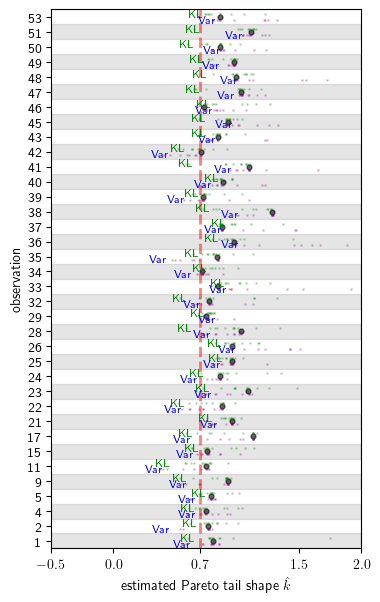

In [225]:
fig = plt.figure(figsize=(4, 7))
ndx_high_khat = loo['KL']['ndx'].tolist()
ymax = (len(ndx_high_khat))
_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]) + 0.2, s=1, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]) - 0.2, s=1, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<3]
ll_ = ll_[ll_.khat<3]
var_ = var_[var_.khat<3]
_ = plt.axvline(x=0.7, linestyle='dashed', linewidth=2, color='red', alpha=0.5)

kl_vals = defaultdict(list)
var_vals = defaultdict(list)
ll_vals = defaultdict(list)

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    kl_vals[y] += [x]
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    var_vals[y] += [x]

for x, v in kl_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)+0.2, color='green', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x) + 0.2, "KL",  ha='center', va='center', color='green', fontsize=8)
    
for x, v in var_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)-0.2, color='purple', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x)-0.2, "Var",  ha='center', va='center', color='blue', fontsize=8)
    
    
#for x, v in var_vals.items():
#    plt.text(min(v), x, "LL",  ha='center', va='center', color='purple', fontsize=8)

_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 2))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat.pdf", bbox_inches='tight')

In [226]:
len(ndx_high_khat)

36

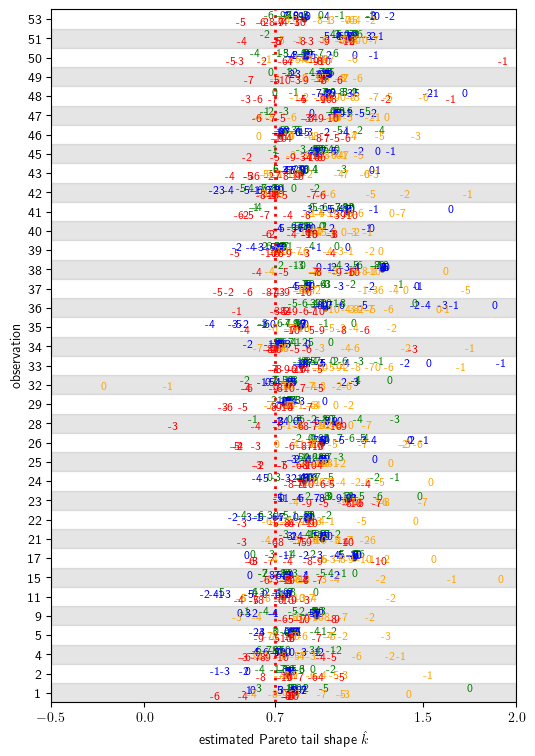

In [227]:
fig = plt.figure(figsize=(6, 9))

_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]), s=0, color='purple', alpha=0.2)
_ = plt.scatter(ll_.khat, np.array([ndx_high_khat.index(i) for i in ll_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(mm1_.khat, np.array([ndx_high_khat.index(i) for i in mm1_['ndx']]), s=0, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<2]
ll_ = ll_[ll_.khat<2]
var_ = var_[var_.khat<2]
mm1_ = mm1_[mm1_.khat<2]
_ = plt.axvline(x=0.7, linestyle='dotted', linewidth=2, color='red')

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.2, str(s),  ha='center', va='center', color='green', fontsize=8)
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.1, str(s),  ha='center', va='center', color='blue', fontsize=8)

for x, y, s in zip( ll_.khat, ll_['ndx'], ll_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.1, str(s),  ha='center', va='center', color='orange', fontsize=8)

for x, y, s in zip( mm1_.khat, mm1_['ndx'], mm1_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.2, str(s),  ha='center', va='center', color='red', fontsize=8)
    
_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 2))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat_detailed.pdf", bbox_inches='tight')

In [228]:
df_ = df.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_ = df_[df_['T']!="MM2"]

df_ = df_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_ = df_.reset_index()
df_['y'] = [y_.tolist()[i][0] for i in df_['ndx'].values]


In [229]:



fpr, tpr, thresholds = metrics.roc_curve(df_['y'], df_.p_psis, pos_label=1)
precision, recall, thresholds_pr = metrics.precision_recall_curve(df_['y'], df_.p_psis)

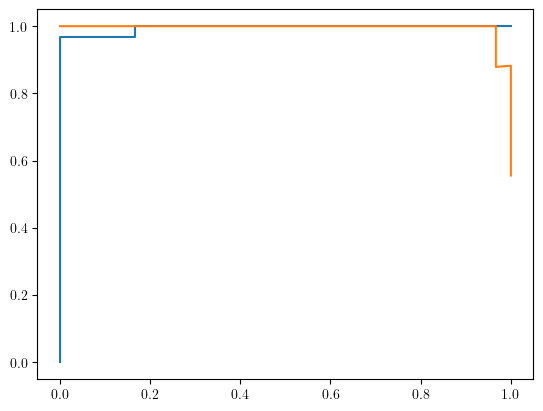

In [230]:
plt.plot(fpr, tpr)
plt.plot(recall, precision)

# Cross-tabulations

In [231]:
df__ = df.explode(['khat', 'ndx'])[['ndx', 'khat', 'T']]
transforms = ["KL", "Var", "LL"]


In [232]:
for T in transforms:
    _df__ = df__.loc[(df__['T']==T) & (df__['khat']<0.7)]
    print(f"{T}: {_df__.groupby('ndx').min().shape[0]}")
    

KL: 32
Var: 21
LL: 25


In [233]:
print(f"{df__.loc[((df__['T']=='KL') | (df__['T']=='Var')) & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

34


In [243]:
print(f"{df__.loc[((df__['T']=='LL') | (df__['T']=='MM1')) &(df__['T']!='I0') & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

40


In [235]:
print(f"{df__.loc[(df__['T']!='MM1') &(df__['T']!='I0') & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

36


# Compare with variational model

In [236]:
lr_model2 = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [237]:

losses = lr_model2.fit(
    data_factory_factory(shuffle=True, repeat=True),
    dataset_size=N,
    batches_per_step=9,
    check_every=int(N/batch_size)*50,
    batch_size=batch_size,
    num_steps=10000,
    max_decay_steps=10,
    max_plateau_epochs=100,
    sample_size=36,
    learning_rate=0.0005,
    lr_decay_factor=0.9
    )



Running optimization for 10000 steps of 9 accumulated batches, checking every 50 steps
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-1


  0%|          | 49/10000 [00:07<18:37,  8.90it/s] 

Step 50: average-batch loss:15077.349829989731 rel loss: 6.63246532895948e+303
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-2


  1%|          | 99/10000 [00:12<18:37,  8.86it/s]

Step 100: average-batch loss:14970.484297590088 rel loss: 0.0071384151825232296
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-3


  1%|▏         | 149/10000 [00:18<18:29,  8.88it/s]

Step 150: average-batch loss:14863.441795265713 rel loss: 0.007201730514292471
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-4


  2%|▏         | 199/10000 [00:23<18:07,  9.01it/s]

Step 200: average-batch loss:14756.118213462418 rel loss: 0.007273158174172194
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-5


  2%|▏         | 249/10000 [00:29<18:17,  8.88it/s]

Step 250: average-batch loss:14655.289272813763 rel loss: 0.006880037559933874
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-6


  3%|▎         | 299/10000 [00:35<18:09,  8.90it/s]

Step 300: average-batch loss:14555.109243102175 rel loss: 0.006882808506508754
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-7


  3%|▎         | 349/10000 [00:40<17:39,  9.11it/s]

Step 350: average-batch loss:14451.097191463017 rel loss: 0.00719751934826119
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-8


  4%|▍         | 399/10000 [00:46<18:01,  8.88it/s]

Step 400: average-batch loss:14353.187798306772 rel loss: 0.006821438870032474
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-9


  4%|▍         | 449/10000 [00:52<17:52,  8.90it/s]

Step 450: average-batch loss:14250.579437844268 rel loss: 0.007200293918576661
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-10


  5%|▍         | 499/10000 [00:57<17:43,  8.93it/s]

Step 500: average-batch loss:14151.39824318609 rel loss: 0.007008579149126426
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-11


  5%|▌         | 549/10000 [01:03<17:33,  8.97it/s]

Step 550: average-batch loss:14051.189349843318 rel loss: 0.007131701868631403
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-12


  6%|▌         | 599/10000 [01:09<18:20,  8.54it/s]

Step 600: average-batch loss:13950.305149313375 rel loss: 0.007231684142400887
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-13


  6%|▋         | 649/10000 [01:15<17:59,  8.66it/s]

Step 650: average-batch loss:13859.077664266879 rel loss: 0.006582507671611509
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-14


  7%|▋         | 699/10000 [01:20<17:30,  8.86it/s]

Step 700: average-batch loss:13757.6290829042 rel loss: 0.0073739872438299695
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-15


  7%|▋         | 749/10000 [01:26<17:32,  8.79it/s]

Step 750: average-batch loss:13659.144434314745 rel loss: 0.0072101623248114425
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-16


  8%|▊         | 799/10000 [01:31<16:58,  9.04it/s]

Step 800: average-batch loss:13563.001235397336 rel loss: 0.007088637481392392
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-17


  8%|▊         | 849/10000 [01:37<17:01,  8.96it/s]

Step 850: average-batch loss:13468.202723389704 rel loss: 0.007038690607396262
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-18


  9%|▉         | 899/10000 [01:43<17:05,  8.88it/s]

Step 900: average-batch loss:13369.495094569369 rel loss: 0.007383048359128374
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-19


  9%|▉         | 949/10000 [01:48<16:36,  9.08it/s]

Step 950: average-batch loss:13271.619253428633 rel loss: 0.007374822866128457
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-20


 10%|▉         | 999/10000 [01:54<16:52,  8.89it/s]

Step 1000: average-batch loss:13181.34504832558 rel loss: 0.006848633790564509
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-21


 10%|█         | 1049/10000 [02:00<16:39,  8.95it/s]

Step 1050: average-batch loss:13088.780969569318 rel loss: 0.007072016788383025
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-22


 11%|█         | 1099/10000 [02:05<16:52,  8.79it/s]

Step 1100: average-batch loss:12989.507885343883 rel loss: 0.007642559294909491
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-23


 11%|█▏        | 1149/10000 [02:11<16:25,  8.98it/s]

Step 1150: average-batch loss:12902.136885884092 rel loss: 0.00677182394145738
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-24


 12%|█▏        | 1199/10000 [02:17<16:37,  8.82it/s]

Step 1200: average-batch loss:12806.416872760281 rel loss: 0.007474378983196418
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-25


 12%|█▏        | 1249/10000 [02:22<16:31,  8.83it/s]

Step 1250: average-batch loss:12710.186418999674 rel loss: 0.007571128431032132
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-26


 13%|█▎        | 1299/10000 [02:28<16:22,  8.86it/s]

Step 1300: average-batch loss:12618.430444298765 rel loss: 0.007271583823831756
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-27


 13%|█▎        | 1349/10000 [02:34<16:21,  8.81it/s]

Step 1350: average-batch loss:12522.041499167299 rel loss: 0.007697542380599521
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-28


 14%|█▍        | 1399/10000 [02:39<16:07,  8.89it/s]

Step 1400: average-batch loss:12433.189637116233 rel loss: 0.007146344956069876
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-29


 14%|█▍        | 1449/10000 [02:45<15:56,  8.94it/s]

Step 1450: average-batch loss:12336.23184339016 rel loss: 0.007859595616956852
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-30


 15%|█▍        | 1499/10000 [02:51<16:12,  8.74it/s]

Step 1500: average-batch loss:12247.404468110173 rel loss: 0.007252751022575914
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-31


 15%|█▌        | 1549/10000 [02:56<15:35,  9.03it/s]

Step 1550: average-batch loss:12160.35530324882 rel loss: 0.007158439263538366
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-32


 16%|█▌        | 1599/10000 [03:02<15:46,  8.88it/s]

Step 1600: average-batch loss:12063.305081818378 rel loss: 0.00804507726300598
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-33


 16%|█▋        | 1649/10000 [03:08<15:32,  8.96it/s]

Step 1650: average-batch loss:11972.932434740382 rel loss: 0.0075480796012657204
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-34


 17%|█▋        | 1699/10000 [03:13<15:30,  8.92it/s]

Step 1700: average-batch loss:11880.256242335732 rel loss: 0.007800858038263057
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-35


 17%|█▋        | 1749/10000 [03:19<15:25,  8.92it/s]

Step 1750: average-batch loss:11794.354441548301 rel loss: 0.007283298226550017
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-36


 18%|█▊        | 1799/10000 [03:25<15:08,  9.02it/s]

Step 1800: average-batch loss:11702.954179722232 rel loss: 0.007810016208081798
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-37


 18%|█▊        | 1849/10000 [03:30<15:11,  8.94it/s]

Step 1850: average-batch loss:11617.392148901841 rel loss: 0.0073649946325069675
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-38


 19%|█▉        | 1899/10000 [03:36<15:20,  8.80it/s]

Step 1900: average-batch loss:11521.135285722192 rel loss: 0.008354807125556255
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-39


 19%|█▉        | 1949/10000 [03:42<14:54,  9.00it/s]

Step 1950: average-batch loss:11436.399240270235 rel loss: 0.007409329079172162
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-40


 20%|█▉        | 1999/10000 [03:48<14:54,  8.95it/s]

Step 2000: average-batch loss:11347.577395448758 rel loss: 0.007827383918712185
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-41


 20%|██        | 2049/10000 [03:53<15:25,  8.59it/s]

Step 2050: average-batch loss:11253.496458126177 rel loss: 0.008360151680204611
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-42


 21%|██        | 2099/10000 [03:59<14:51,  8.86it/s]

Step 2100: average-batch loss:11172.905340126646 rel loss: 0.007213085186544458
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-43


 21%|██▏       | 2149/10000 [04:05<14:49,  8.82it/s]

Step 2150: average-batch loss:11080.358626156878 rel loss: 0.008352321174090684
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-44


 22%|██▏       | 2199/10000 [04:10<14:34,  8.92it/s]

Step 2200: average-batch loss:10994.324716549481 rel loss: 0.007825301855774009
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-45


 22%|██▏       | 2249/10000 [04:16<14:44,  8.76it/s]

Step 2250: average-batch loss:10905.394963281076 rel loss: 0.008154656806822237
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-46


 23%|██▎       | 2299/10000 [04:21<14:34,  8.81it/s]

Step 2300: average-batch loss:10810.647765751355 rel loss: 0.008764247950977078
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-47


 23%|██▎       | 2349/10000 [04:27<14:19,  8.90it/s]

Step 2350: average-batch loss:10734.417746161325 rel loss: 0.007101458261887558
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-48


 24%|██▍       | 2399/10000 [04:33<14:14,  8.89it/s]

Step 2400: average-batch loss:10640.967933140426 rel loss: 0.008782078247774588
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-49


 24%|██▍       | 2449/10000 [04:38<14:13,  8.85it/s]

Step 2450: average-batch loss:10556.66353071852 rel loss: 0.007985894613065045
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-50


 25%|██▍       | 2499/10000 [04:44<13:54,  8.99it/s]

Step 2500: average-batch loss:10469.708839701281 rel loss: 0.00830535904565999
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-51


 25%|██▌       | 2549/10000 [04:50<13:37,  9.12it/s]

Step 2550: average-batch loss:10385.139628241213 rel loss: 0.008143290748839956
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-52


 26%|██▌       | 2599/10000 [04:55<14:11,  8.70it/s]

Step 2600: average-batch loss:10300.610059626984 rel loss: 0.008206268184594308
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-53


 26%|██▋       | 2649/10000 [05:01<13:52,  8.84it/s]

Step 2650: average-batch loss:10212.876252694725 rel loss: 0.008590509153492434
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-54


 27%|██▋       | 2699/10000 [05:07<13:42,  8.88it/s]

Step 2700: average-batch loss:10131.772401782346 rel loss: 0.008004902567502565
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-55


 27%|██▋       | 2749/10000 [05:12<13:47,  8.77it/s]

Step 2750: average-batch loss:10040.44637425367 rel loss: 0.009095813485231046
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-56


 28%|██▊       | 2799/10000 [05:18<13:40,  8.78it/s]

Step 2800: average-batch loss:9956.240159779838 rel loss: 0.008457631909483194
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-57


 28%|██▊       | 2849/10000 [05:24<13:22,  8.91it/s]

Step 2850: average-batch loss:9868.671473560935 rel loss: 0.008873401698851523
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-58


 29%|██▉       | 2899/10000 [05:29<13:29,  8.77it/s]

Step 2900: average-batch loss:9789.604304174256 rel loss: 0.008076646096202773
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-59


 29%|██▉       | 2949/10000 [05:35<13:20,  8.81it/s]

Step 2950: average-batch loss:9707.95300899036 rel loss: 0.008410763330671261
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-60


 30%|██▉       | 2999/10000 [05:41<13:11,  8.84it/s]

Step 3000: average-batch loss:9619.453692526098 rel loss: 0.00920003560420714
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-61


 30%|███       | 3049/10000 [05:46<13:11,  8.78it/s]

Step 3050: average-batch loss:9533.989315504867 rel loss: 0.008964177973457879
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-62


 31%|███       | 3099/10000 [05:52<13:23,  8.58it/s]

Step 3100: average-batch loss:9448.566499428804 rel loss: 0.00904082286781039
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-63


 31%|███▏      | 3149/10000 [05:58<12:52,  8.87it/s]

Step 3150: average-batch loss:9365.155934680628 rel loss: 0.008906479008992612
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-64


 32%|███▏      | 3199/10000 [06:04<12:36,  8.99it/s]

Step 3200: average-batch loss:9281.3438208769 rel loss: 0.009030170137130976
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-65


 32%|███▏      | 3249/10000 [06:09<12:31,  8.98it/s]

Step 3250: average-batch loss:9197.857561105664 rel loss: 0.009076707180623105
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-66


 33%|███▎      | 3299/10000 [06:15<12:27,  8.97it/s]

Step 3300: average-batch loss:9117.204536291629 rel loss: 0.008846244974870379
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-67


 33%|███▎      | 3349/10000 [06:21<12:23,  8.95it/s]

Step 3350: average-batch loss:9034.82394433041 rel loss: 0.009118118124804708
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-68


 34%|███▍      | 3399/10000 [06:26<12:19,  8.92it/s]

Step 3400: average-batch loss:8949.924135882968 rel loss: 0.009486092525304574
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-69


 34%|███▍      | 3449/10000 [06:32<12:11,  8.96it/s]

Step 3450: average-batch loss:8869.980706128252 rel loss: 0.009012807626456634
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-70


 35%|███▍      | 3499/10000 [06:37<12:05,  8.96it/s]

Step 3500: average-batch loss:8794.152613348091 rel loss: 0.008622558205899904
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-71


 35%|███▌      | 3549/10000 [06:43<12:03,  8.92it/s]

Step 3550: average-batch loss:8708.610073411217 rel loss: 0.009822754631999112
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-72


 36%|███▌      | 3599/10000 [06:49<12:01,  8.87it/s]

Step 3600: average-batch loss:8621.976976638427 rel loss: 0.010047938774079957
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-73


 36%|███▋      | 3649/10000 [06:54<11:50,  8.94it/s]

Step 3650: average-batch loss:8543.979134522946 rel loss: 0.009128983215832262
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-74


 37%|███▋      | 3699/10000 [07:00<11:49,  8.88it/s]

Step 3700: average-batch loss:8460.671496682915 rel loss: 0.009846456971257253
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-75


 37%|███▋      | 3749/10000 [07:06<11:50,  8.80it/s]

Step 3750: average-batch loss:8377.765009192597 rel loss: 0.009896014915594768
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-76


 38%|███▊      | 3799/10000 [07:11<11:40,  8.86it/s]

Step 3800: average-batch loss:8301.068010445068 rel loss: 0.00923941336837901
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-77


 38%|███▊      | 3849/10000 [07:17<11:30,  8.91it/s]

Step 3850: average-batch loss:8216.35649337175 rel loss: 0.010310107301412215
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-78


 39%|███▉      | 3899/10000 [07:23<11:19,  8.98it/s]

Step 3900: average-batch loss:8132.352236465395 rel loss: 0.010329638272390617
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-79


 39%|███▉      | 3949/10000 [07:28<11:22,  8.86it/s]

Step 3950: average-batch loss:8054.986156407638 rel loss: 0.009604744012652775
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-80


 40%|███▉      | 3999/10000 [07:34<11:41,  8.55it/s]

Step 4000: average-batch loss:7972.108890121345 rel loss: 0.010395902442952142
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-81


 40%|████      | 4049/10000 [07:40<11:22,  8.72it/s]

Step 4050: average-batch loss:7897.464888913489 rel loss: 0.009451640780656361
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-82


 41%|████      | 4099/10000 [07:45<10:55,  9.00it/s]

Step 4100: average-batch loss:7815.156035434581 rel loss: 0.010531952670645639
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-83


 41%|████▏     | 4149/10000 [07:51<10:49,  9.01it/s]

Step 4150: average-batch loss:7731.840463033664 rel loss: 0.010775645565794283
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-84


 42%|████▏     | 4199/10000 [07:57<11:03,  8.74it/s]

Step 4200: average-batch loss:7653.352113979086 rel loss: 0.01025542113908698
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-85


 42%|████▏     | 4249/10000 [08:02<10:41,  8.96it/s]

Step 4250: average-batch loss:7576.919425099824 rel loss: 0.010087567861163453
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-86


 43%|████▎     | 4299/10000 [08:08<10:31,  9.03it/s]

Step 4300: average-batch loss:7496.241892002854 rel loss: 0.010762397246417412
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-87


 43%|████▎     | 4349/10000 [08:14<10:35,  8.89it/s]

Step 4350: average-batch loss:7415.654695309196 rel loss: 0.01086717221941768
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-88


 44%|████▍     | 4399/10000 [08:19<10:43,  8.71it/s]

Step 4400: average-batch loss:7339.742808443745 rel loss: 0.010342581320168378
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-89


 44%|████▍     | 4449/10000 [08:25<10:45,  8.60it/s]

Step 4450: average-batch loss:7262.116336402047 rel loss: 0.01068923554041518
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-90


 45%|████▍     | 4499/10000 [08:31<10:08,  9.04it/s]

Step 4500: average-batch loss:7184.053993542784 rel loss: 0.010866057372261824
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-91


 45%|████▌     | 4549/10000 [08:36<10:27,  8.68it/s]

Step 4550: average-batch loss:7102.391140200015 rel loss: 0.01149793805082798
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-92


 46%|████▌     | 4599/10000 [08:42<10:11,  8.84it/s]

Step 4600: average-batch loss:7028.299223939711 rel loss: 0.01054194107273251
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-93


 46%|████▋     | 4649/10000 [08:48<09:57,  8.95it/s]

Step 4650: average-batch loss:6947.0344385517965 rel loss: 0.011697766306863895
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-94


 47%|████▋     | 4699/10000 [08:53<09:52,  8.95it/s]

Step 4700: average-batch loss:6873.090683596034 rel loss: 0.010758443087655391
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-95


 47%|████▋     | 4749/10000 [08:59<09:49,  8.91it/s]

Step 4750: average-batch loss:6787.111557102927 rel loss: 0.01266799960037896
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-96


 48%|████▊     | 4799/10000 [09:04<09:48,  8.84it/s]

Step 4800: average-batch loss:6714.2207035180745 rel loss: 0.010856189691032853
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-97


 48%|████▊     | 4849/10000 [09:10<09:39,  8.88it/s]

Step 4850: average-batch loss:6636.135763973523 rel loss: 0.011766627796926835
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-98


 49%|████▉     | 4899/10000 [09:16<09:28,  8.97it/s]

Step 4900: average-batch loss:6558.458041182573 rel loss: 0.01184390024350058
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-99


 49%|████▉     | 4949/10000 [09:21<09:42,  8.67it/s]

Step 4950: average-batch loss:6486.63091847667 rel loss: 0.011073101523521102
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-100


 50%|████▉     | 4999/10000 [09:27<09:25,  8.84it/s]

Step 5000: average-batch loss:6406.395541303267 rel loss: 0.012524262146492434
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-101


 50%|█████     | 5049/10000 [09:33<09:23,  8.79it/s]

Step 5050: average-batch loss:6334.527673284807 rel loss: 0.011345418589227312
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-102


 51%|█████     | 5099/10000 [09:39<09:23,  8.69it/s]

Step 5100: average-batch loss:6257.847210475451 rel loss: 0.012253489136167329
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-103


 51%|█████▏    | 5149/10000 [09:44<09:07,  8.87it/s]

Step 5150: average-batch loss:6177.852483820267 rel loss: 0.012948630104828466
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-104


 52%|█████▏    | 5199/10000 [09:50<09:20,  8.57it/s]

Step 5200: average-batch loss:6105.124802506182 rel loss: 0.011912562587455908
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-105


 52%|█████▏    | 5249/10000 [09:56<09:03,  8.74it/s]

Step 5250: average-batch loss:6023.908821893193 rel loss: 0.013482272559939714
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-106


 53%|█████▎    | 5299/10000 [10:01<08:56,  8.76it/s]

Step 5300: average-batch loss:5954.0834005171055 rel loss: 0.011727316646257117
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-107


 53%|█████▎    | 5349/10000 [10:07<08:45,  8.85it/s]

Step 5350: average-batch loss:5879.239454290952 rel loss: 0.012730208865966222
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-108


 54%|█████▍    | 5399/10000 [10:13<08:37,  8.88it/s]

Step 5400: average-batch loss:5805.012878611888 rel loss: 0.012786634109382734
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-109


 54%|█████▍    | 5449/10000 [10:18<08:25,  9.01it/s]

Step 5450: average-batch loss:5728.180271869432 rel loss: 0.013413091609524551
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-110


 55%|█████▍    | 5499/10000 [10:24<08:35,  8.73it/s]

Step 5500: average-batch loss:5661.14186895848 rel loss: 0.011841851778797654
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-111


 55%|█████▌    | 5549/10000 [10:30<08:21,  8.88it/s]

Step 5550: average-batch loss:5580.958625521422 rel loss: 0.014367288635752368
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-112


 56%|█████▌    | 5599/10000 [10:35<08:12,  8.94it/s]

Step 5600: average-batch loss:5505.5123133556735 rel loss: 0.013703776846112032
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-113


 56%|█████▋    | 5649/10000 [10:41<08:08,  8.90it/s]

Step 5650: average-batch loss:5438.685340328742 rel loss: 0.012287339466285773
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-114


 57%|█████▋    | 5699/10000 [10:47<08:17,  8.64it/s]

Step 5700: average-batch loss:5361.307054834026 rel loss: 0.014432727822397061
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-115


 57%|█████▋    | 5749/10000 [10:52<07:54,  8.95it/s]

Step 5750: average-batch loss:5291.927852247021 rel loss: 0.013110383309089337
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-116


 58%|█████▊    | 5799/10000 [10:58<08:04,  8.67it/s]

Step 5800: average-batch loss:5222.875976809308 rel loss: 0.013221044448368812
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-117


 58%|█████▊    | 5849/10000 [11:04<07:36,  9.08it/s]

Step 5850: average-batch loss:5142.470352292844 rel loss: 0.015635602931694848
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-118


 59%|█████▉    | 5899/10000 [11:09<07:29,  9.12it/s]

Step 5900: average-batch loss:5072.4738005356685 rel loss: 0.013799292911041471
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-119


 59%|█████▉    | 5949/10000 [11:15<07:38,  8.83it/s]

Step 5950: average-batch loss:5007.641893649461 rel loss: 0.012946594078227775
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-120


 60%|█████▉    | 5999/10000 [11:21<07:29,  8.91it/s]

Step 6000: average-batch loss:4933.313496746592 rel loss: 0.015066627521621483
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-121


 60%|██████    | 6049/10000 [11:26<07:15,  9.07it/s]

Step 6050: average-batch loss:4865.962956917107 rel loss: 0.013841153421389045
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-122


 61%|██████    | 6099/10000 [11:32<07:08,  9.11it/s]

Step 6100: average-batch loss:4794.004976812928 rel loss: 0.015009992783114741
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-123


 61%|██████▏   | 6149/10000 [11:37<07:04,  9.08it/s]

Step 6150: average-batch loss:4718.318632649982 rel loss: 0.016040956547361953
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-124


 62%|██████▏   | 6199/10000 [11:43<06:55,  9.15it/s]

Step 6200: average-batch loss:4653.107216256569 rel loss: 0.014014595701896511
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-125


 62%|██████▏   | 6249/10000 [11:49<07:05,  8.82it/s]

Step 6250: average-batch loss:4581.923180594934 rel loss: 0.015535842233913681
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-126


 63%|██████▎   | 6299/10000 [11:54<06:55,  8.91it/s]

Step 6300: average-batch loss:4511.70009689998 rel loss: 0.015564661255566303
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-127


 63%|██████▎   | 6349/10000 [12:00<06:52,  8.85it/s]

Step 6350: average-batch loss:4446.610574060221 rel loss: 0.01463800837866624
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-128


 64%|██████▍   | 6399/10000 [12:06<06:54,  8.68it/s]

Step 6400: average-batch loss:4372.57703586683 rel loss: 0.016931328501732026
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-129


 64%|██████▍   | 6449/10000 [12:11<06:39,  8.89it/s]

Step 6450: average-batch loss:4306.714785853411 rel loss: 0.015292921237728928
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-130


 65%|██████▍   | 6499/10000 [12:17<06:37,  8.80it/s]

Step 6500: average-batch loss:4242.221954207842 rel loss: 0.01520260663909835
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-131


 65%|██████▌   | 6549/10000 [12:23<06:32,  8.80it/s]

Step 6550: average-batch loss:4173.695775224442 rel loss: 0.016418585032042805
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-132


 66%|██████▌   | 6599/10000 [12:29<06:30,  8.71it/s]

Step 6600: average-batch loss:4109.3084572370935 rel loss: 0.015668650493722996
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-133


 66%|██████▋   | 6649/10000 [12:34<06:17,  8.88it/s]

Step 6650: average-batch loss:4042.5086065933624 rel loss: 0.016524355825682117
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-134


 67%|██████▋   | 6699/10000 [12:40<06:17,  8.74it/s]

Step 6700: average-batch loss:3978.2994865410997 rel loss: 0.016139840720762036
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-135


 67%|██████▋   | 6749/10000 [12:46<06:12,  8.73it/s]

Step 6750: average-batch loss:3914.544790368999 rel loss: 0.016286618134746318
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-136


 68%|██████▊   | 6799/10000 [12:51<05:58,  8.94it/s]

Step 6800: average-batch loss:3850.5247036497167 rel loss: 0.016626328006310705
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-137


 68%|██████▊   | 6849/10000 [12:57<05:53,  8.90it/s]

Step 6850: average-batch loss:3780.7575158986783 rel loss: 0.018453229930154576
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-138


 69%|██████▉   | 6899/10000 [13:03<05:57,  8.66it/s]

Step 6900: average-batch loss:3721.760785400244 rel loss: 0.01585183301674498
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-139


 69%|██████▉   | 6949/10000 [13:08<05:41,  8.92it/s]

Step 6950: average-batch loss:3653.7561064919523 rel loss: 0.01861226554981646
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-140


 70%|██████▉   | 6999/10000 [13:14<05:39,  8.84it/s]

Step 7000: average-batch loss:3593.768613407204 rel loss: 0.01669208553409754
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-141


 70%|███████   | 7049/10000 [13:20<05:35,  8.80it/s]

Step 7050: average-batch loss:3530.23157969351 rel loss: 0.01799797896522426
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-142


 71%|███████   | 7099/10000 [13:25<05:24,  8.94it/s]

Step 7100: average-batch loss:3471.8539606098116 rel loss: 0.016814537634942655
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-143


 71%|███████▏  | 7149/10000 [13:31<05:19,  8.91it/s]

Step 7150: average-batch loss:3405.5499867843146 rel loss: 0.019469387935222886
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-144


 72%|███████▏  | 7199/10000 [13:37<05:17,  8.81it/s]

Step 7200: average-batch loss:3349.332868211751 rel loss: 0.01678457196838091
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-145


 72%|███████▏  | 7249/10000 [13:42<05:05,  8.99it/s]

Step 7250: average-batch loss:3284.338696670202 rel loss: 0.019789119681061722
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-146


 73%|███████▎  | 7299/10000 [13:48<05:06,  8.81it/s]

Step 7300: average-batch loss:3226.40938905033 rel loss: 0.01795472943280858
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-147


 73%|███████▎  | 7349/10000 [13:53<05:02,  8.77it/s]

Step 7350: average-batch loss:3167.8273455492463 rel loss: 0.01849281451004288
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-148


 74%|███████▍  | 7399/10000 [13:59<04:50,  8.95it/s]

Step 7400: average-batch loss:3113.3199821621615 rel loss: 0.017507793512837082
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-149


 74%|███████▍  | 7449/10000 [14:05<04:49,  8.81it/s]

Step 7450: average-batch loss:3054.9943570133814 rel loss: 0.019091892924411255
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-150


 75%|███████▍  | 7499/10000 [14:11<04:42,  8.85it/s]

Step 7500: average-batch loss:2993.142961112626 rel loss: 0.02066436408295172
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-151


 75%|███████▌  | 7549/10000 [14:16<04:33,  8.96it/s]

Step 7550: average-batch loss:2936.6142686352728 rel loss: 0.019249614456046227
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-152


 76%|███████▌  | 7599/10000 [14:22<04:31,  8.84it/s]

Step 7600: average-batch loss:2882.1086842310547 rel loss: 0.018911703331118537
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-153


 76%|███████▋  | 7649/10000 [14:28<04:21,  9.01it/s]

Step 7650: average-batch loss:2829.296926739773 rel loss: 0.01866603571797507
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-154


 77%|███████▋  | 7699/10000 [14:33<04:13,  9.09it/s]

Step 7700: average-batch loss:2772.51443495753 rel loss: 0.020480503569718277
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-155


 77%|███████▋  | 7749/10000 [14:39<04:16,  8.77it/s]

Step 7750: average-batch loss:2717.978229630587 rel loss: 0.020064989753194245
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-156


 78%|███████▊  | 7799/10000 [14:45<04:08,  8.85it/s]

Step 7800: average-batch loss:2667.614750179692 rel loss: 0.01887959250768979
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-157


 78%|███████▊  | 7849/10000 [14:50<04:08,  8.64it/s]

Step 7850: average-batch loss:2608.893894764084 rel loss: 0.02250795079610461
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-158


 79%|███████▉  | 7899/10000 [14:56<03:51,  9.06it/s]

Step 7900: average-batch loss:2559.8148352525877 rel loss: 0.019172894396736116
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-159


 79%|███████▉  | 7949/10000 [15:02<03:48,  8.99it/s]

Step 7950: average-batch loss:2509.117493039741 rel loss: 0.02020524840047565
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-160


 80%|███████▉  | 7999/10000 [15:07<03:46,  8.85it/s]

Step 8000: average-batch loss:2458.0424539719984 rel loss: 0.020778745698720333
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-161


 80%|████████  | 8049/10000 [15:13<03:42,  8.76it/s]

Step 8050: average-batch loss:2406.2904474312913 rel loss: 0.02150696587602389
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-162


 81%|████████  | 8099/10000 [15:19<03:31,  8.97it/s]

Step 8100: average-batch loss:2359.3936128759105 rel loss: 0.019876647245059435
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-163


 81%|████████▏ | 8149/10000 [15:24<03:26,  8.95it/s]

Step 8150: average-batch loss:2312.168978756126 rel loss: 0.02042438703817835
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-164


 82%|████████▏ | 8199/10000 [15:30<03:22,  8.89it/s]

Step 8200: average-batch loss:2261.7903513636866 rel loss: 0.022273782962273593
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-165


 82%|████████▏ | 8249/10000 [15:36<03:19,  8.78it/s]

Step 8250: average-batch loss:2215.770837162784 rel loss: 0.020769076580062225
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-166


 83%|████████▎ | 8299/10000 [15:41<03:13,  8.80it/s]

Step 8300: average-batch loss:2169.798481546049 rel loss: 0.021187384915108947
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-167


 83%|████████▎ | 8349/10000 [15:47<03:04,  8.95it/s]

Step 8350: average-batch loss:2123.4586256576117 rel loss: 0.021822820246420578
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-168


 84%|████████▍ | 8399/10000 [15:53<02:56,  9.05it/s]

Step 8400: average-batch loss:2078.8328994862636 rel loss: 0.0214667211503033
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-169


 84%|████████▍ | 8449/10000 [15:58<02:58,  8.68it/s]

Step 8450: average-batch loss:2033.29491881225 rel loss: 0.022396151317101924
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-170


 85%|████████▍ | 8499/10000 [16:04<02:52,  8.71it/s]

Step 8500: average-batch loss:1993.1246361933433 rel loss: 0.020154425814347274
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-171


 85%|████████▌ | 8549/10000 [16:10<02:41,  9.00it/s]

Step 8550: average-batch loss:1948.0933815187366 rel loss: 0.023115552417461802
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-172


 86%|████████▌ | 8599/10000 [16:15<02:35,  8.99it/s]

Step 8600: average-batch loss:1910.3857195914768 rel loss: 0.01973824528761831
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-173


 86%|████████▋ | 8649/10000 [16:21<02:34,  8.74it/s]

Step 8650: average-batch loss:1864.1680655676557 rel loss: 0.02479264336595498
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-174


 87%|████████▋ | 8699/10000 [16:27<02:26,  8.87it/s]

Step 8700: average-batch loss:1827.0086962010562 rel loss: 0.020338912148511353
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-175


 87%|████████▋ | 8749/10000 [16:32<02:23,  8.74it/s]

Step 8750: average-batch loss:1784.8292158345405 rel loss: 0.02363222205929302
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-176


 88%|████████▊ | 8799/10000 [16:38<02:12,  9.07it/s]

Step 8800: average-batch loss:1748.8274690748142 rel loss: 0.020586219850933826
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-177


 88%|████████▊ | 8849/10000 [16:44<02:09,  8.89it/s]

Step 8850: average-batch loss:1712.6635998029835 rel loss: 0.02111557066781286
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-178


 89%|████████▉ | 8899/10000 [16:49<02:07,  8.63it/s]

Step 8900: average-batch loss:1678.4712085814726 rel loss: 0.020371151466105828
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-179


 89%|████████▉ | 8949/10000 [16:55<01:57,  8.98it/s]

Step 8950: average-batch loss:1636.4497738651148 rel loss: 0.025678413958961782
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-180


 90%|████████▉ | 8999/10000 [17:01<01:52,  8.87it/s]

Step 9000: average-batch loss:1605.1620294923864 rel loss: 0.019491953957210657
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-181


 90%|█████████ | 9049/10000 [17:06<01:47,  8.81it/s]

Step 9050: average-batch loss:1572.3109844596238 rel loss: 0.02089347804439142
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-182


 91%|█████████ | 9099/10000 [17:12<01:44,  8.62it/s]

Step 9100: average-batch loss:1538.204964869382 rel loss: 0.02217261052277128
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-183


 91%|█████████▏| 9149/10000 [17:18<01:38,  8.67it/s]

Step 9150: average-batch loss:1506.347325886626 rel loss: 0.021148933207688087
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-184


 92%|█████████▏| 9199/10000 [17:23<01:28,  9.02it/s]

Step 9200: average-batch loss:1477.45564690532 rel loss: 0.019555022881277435
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-185


 92%|█████████▏| 9249/10000 [17:29<01:25,  8.78it/s]

Step 9250: average-batch loss:1448.0270932271078 rel loss: 0.02032320653105118
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-186


 93%|█████████▎| 9299/10000 [17:35<01:18,  8.87it/s]

Step 9300: average-batch loss:1416.9381467306318 rel loss: 0.021940934096671014
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-187


 93%|█████████▎| 9349/10000 [17:40<01:11,  9.05it/s]

Step 9350: average-batch loss:1388.5485589777554 rel loss: 0.02044551310022369
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-188


 94%|█████████▍| 9399/10000 [17:46<01:07,  8.90it/s]

Step 9400: average-batch loss:1361.2572683320973 rel loss: 0.020048591313747206
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-189


 94%|█████████▍| 9449/10000 [17:52<01:01,  8.96it/s]

Step 9450: average-batch loss:1332.8051234660404 rel loss: 0.02134756564565519
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-190


 95%|█████████▍| 9499/10000 [17:57<00:56,  8.86it/s]

Step 9500: average-batch loss:1307.0354068919194 rel loss: 0.01971615798488616
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-191


 95%|█████████▌| 9549/10000 [18:03<00:50,  8.87it/s]

Step 9550: average-batch loss:1282.4985173995785 rel loss: 0.019132099694035013
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-192


 96%|█████████▌| 9599/10000 [18:09<00:45,  8.84it/s]

Step 9600: average-batch loss:1260.4455468899946 rel loss: 0.01749617075009477
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-193


 96%|█████████▋| 9649/10000 [18:14<00:39,  8.83it/s]

Step 9650: average-batch loss:1235.7760452569207 rel loss: 0.019962760831753322
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-194


 97%|█████████▋| 9699/10000 [18:20<00:34,  8.85it/s]

Step 9700: average-batch loss:1214.7102970058277 rel loss: 0.017342199455309293
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-195


 97%|█████████▋| 9749/10000 [18:26<00:28,  8.74it/s]

Step 9750: average-batch loss:1194.0041244486688 rel loss: 0.017341793158980878
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-196


 98%|█████████▊| 9799/10000 [18:31<00:22,  8.80it/s]

Step 9800: average-batch loss:1172.7889093138167 rel loss: 0.01808954276969146
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-197


 98%|█████████▊| 9849/10000 [18:37<00:16,  8.96it/s]

Step 9850: average-batch loss:1153.7600976596025 rel loss: 0.016492866838447688
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-198


 99%|█████████▉| 9899/10000 [18:43<00:11,  8.67it/s]

Step 9900: average-batch loss:1135.6051647112358 rel loss: 0.015987011606259403
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-199


 99%|█████████▉| 9949/10000 [18:48<00:05,  8.71it/s]

Step 9950: average-batch loss:1116.5959696998752 rel loss: 0.01702423752834249
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-200


100%|█████████▉| 9999/10000 [18:54<00:00,  8.83it/s]

Step 10000: average-batch loss:1100.1728004544811 rel loss: 0.014927808830221656
Saved a checkpoint: /tmp/tfcheckpoints/e43f9a3a-1561-463f-afa8-d0bbf32478d5/e43f9a3a-1561-463f-afa8-d0bbf32478d5-201


100%|██████████| 10000/10000 [18:54<00:00,  8.11it/s]

Terminating because we are out of iterations


100%|██████████| 10000/10000 [18:54<00:00,  8.81it/s]


In [238]:
base = 4
h_vals = [4**-r for r in range(9)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat_advi = {}
    reduced_ndx_advi = {}
    n_sample = [1000]
    records_advi = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(range(fit.stan_variables()['beta0'].shape[0]), size=n_samples, replace=False)
        reduced_ndx_advi[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat_advi[n_samples] = {}
        params_ = fit.stan_variables()
        params_ = {k: v[sample_ndx] for k, v in params_.items()}

        params_["c"] = params_["c"][:, tf.newaxis]
        params_["tau"] = params_["tau"][:, tf.newaxis]
        params_["caux"] = params_["caux"][:, tf.newaxis]
        params_["beta0"] = params_["beta0"][:, tf.newaxis]

        for h in h_vals:
            loo_khat_advi[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model2, batch, params_, h, variational=False)
            reduced_ndx_advi[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "LL", "KL", "Var", "MM1", "MM2"]:
                loo_khat_advi[n_samples][h][T] = np.array(loo[T]["khat"])

                records_advi += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx_advi[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx_advi)

  0%|          | 0/1 [00:00<?, ?it/s]/home/josh/workspace/bayesianquilts/bayesianquilts/sampler/nppsis.py:350: RuntimeWarning: overflow encountered in expm1
  np.expm1(x, out=x)
100%|██████████| 1/1 [02:11<00:00, 131.81s/it]

{1000: {1: {'I0': [0, 4, 5, 6, 7, 9, 10, 11, 13, 14, 16, 18, 19, 20, 24, 27, 31, 32, 35, 39, 42, 44, 46, 52], 'I': [], 'LL': [], 'KL': [41], 'Var': [1], 'MM1': [], 'MM2': []}, 0.25: {'I0': [0, 4, 5, 6, 7, 9, 10, 11, 13, 14, 16, 18, 19, 20, 24, 27, 31, 32, 35, 39, 42, 44, 46, 52], 'I': [], 'LL': [], 'KL': [], 'Var': [2, 15], 'MM1': [36], 'MM2': []}, 0.0625: {'I0': [0, 4, 5, 6, 7, 9, 10, 11, 13, 14, 16, 18, 19, 20, 24, 27, 31, 32, 35, 39, 42, 44, 46, 52], 'I': [], 'LL': [51], 'KL': [3, 12, 22, 28, 38, 47, 50, 51], 'Var': [2, 8, 12, 30], 'MM1': [8, 25, 26, 33, 40, 41, 43, 51, 53], 'MM2': []}, 0.015625: {'I0': [0, 4, 5, 6, 7, 9, 10, 11, 13, 14, 16, 18, 19, 20, 24, 27, 31, 32, 35, 39, 42, 44, 46, 52], 'I': [], 'LL': [12, 47, 50], 'KL': [43, 47, 49, 51], 'Var': [1, 8, 30], 'MM1': [8, 15, 17, 21, 22, 26, 36, 37, 38, 41, 45, 47, 49], 'MM2': []}, 0.00390625: {'I0': [0, 4, 5, 6, 7, 9, 10, 11, 13, 14, 16, 18, 19, 20, 24, 27, 31, 32, 35, 39, 42, 44, 46, 52], 'I': [], 'LL': [17, 50], 'KL': [8], 'Va

In [239]:
df_advi = pd.DataFrame(records_advi)
df_advi['rho_rank'] = np.emath.logn(base, df_advi['h']) 

I0_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I0")]

kl_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="KL")]
var_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="Var")]
ll_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="LL")]
mm1_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="MM1")]
I_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I")]

kl_advi = kl_advi.explode(['khat', 'ndx'])
var_advi = var_advi.explode(['khat', 'ndx'])
ll_advi = ll_advi.explode(['khat', 'ndx'])
I_advi = I_advi.explode(['khat', 'ndx'])
mm1_advi = mm1_advi.explode(['khat', 'ndx'])

original_advi = I_advi[['khat', 'ndx']].drop_duplicates()


In [240]:
df_advi_ = df_advi.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_advi_ = df_advi_[df_advi_['T']!="MM2"]

df_advi_ = df_advi_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_advi_ = df_advi_.reset_index()
df_advi_['y'] = [y_.tolist()[i][0] for i in df_advi_['ndx'].values]

In [241]:
fpr_advi, tpr_advi, thresholds_advi = metrics.roc_curve(df_advi_['y'], df_advi_.p_psis, pos_label=1)
precision_advi, recall_advi, thresholds_pr_advi = metrics.precision_recall_curve(df_advi_['y'], df_advi_.p_psis)

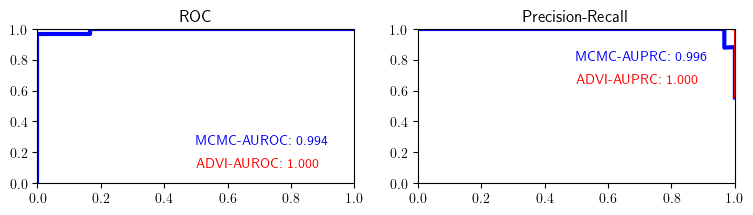

In [242]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(fpr, tpr, linewidth=3, color="blue")
ax[0].text(0.5, 0.25, f"MCMC-AUROC: {metrics.auc(fpr, tpr):.3f}", color="blue")

ax[0].plot(fpr_advi, tpr_advi, color="red")
ax[0].text(0.5, 0.1, f"ADVI-AUROC: {metrics.auc(fpr_advi, tpr_advi):.3f}", color="red")

ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(recall, precision, linewidth=3, color="blue")
ax[1].plot(recall_advi, precision_advi, color="red")
ax[1].text(0.5, 0.8, f"MCMC-AUPRC: {metrics.auc(recall, precision):.3f}", color="blue")
ax[1].text(0.5, 0.65, f"ADVI-AUPRC: {metrics.auc(recall_advi, precision_advi):.3f}", color="red")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

_ = plt.savefig("roccurve.pdf", bbox_inches='tight')